After the one-store-one-product approach seemed to be promising. We'll try it now for the whole dataset.

In [32]:
import pandas as pd
import numpy as np
import re

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [78]:
df = pd.read_csv('case_study_data_ver1.csv', sep = ';')

In [3]:
def check_nulls(df):
    print('{} rows'.format(len(df)))
    cols = list(df.keys())
    print('{} columns'.format(len(cols)))

    if df.isna().sum().sum() > 0:
        for col in range(len(cols)):
            if df[cols[col]].isna().sum() > 0:
                print('{} has {} NULL values'.format(cols[col],df[cols[col]].isna().sum()))
    else:
        print('No NULL values found')

In [4]:
check_nulls(df)

979971 rows
35 columns
ITEM_ID has 2 NULL values
DATE_ID has 2 NULL values
STORE_ID has 2 NULL values
NUM_HOLIDAY_WHIT_TO has 23239 NULL values
QTY has 2 NULL values
PRICE has 2 NULL values
CUSTOMER has 21 NULL values


In [79]:
df = df.dropna() # getting rid of all NULLs

In [80]:
df['QTY'] = df['QTY'].astype(str)
outtakes = df[df.QTY.str.contains('[a-zA-Z]|\.\d\d$|\.\d\d\d\d$')]
df = df.drop(outtakes.index)
df['QTY'] = df['QTY'].apply(lambda x: re.sub('\.','',re.sub('\..$','',x))).astype(float)
df = df.drop([key for key in list(df.keys()) if df[key].sum()==0], axis=1)

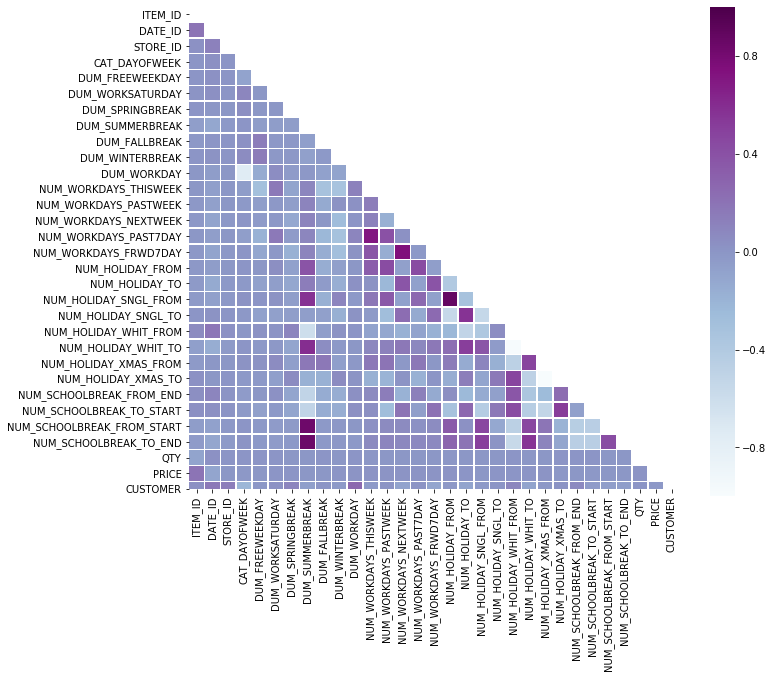

In [15]:
# Compute the correlation matrix 
corr_all = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask, square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

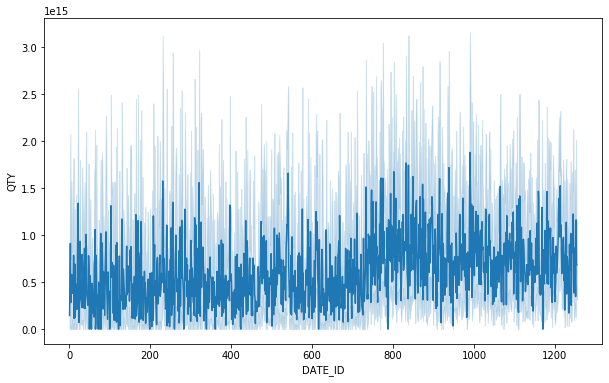

In [16]:
plt.figure(figsize = (10, 6))
sns.lineplot(x="DATE_ID", y="QTY", data=df.sample(frac=0.25))
plt.show()

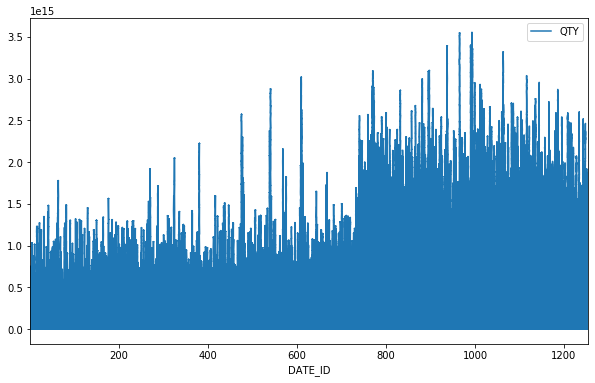

In [17]:
plt.figure(figsize = (10, 6))
decomposition = seasonal_decompose(df[['DATE_ID','QTY']], model = 'additive', freq = 365)
decomposition.trend.plot(x='DATE_ID',y='QTY',ax = plt.gca())
plt.show()

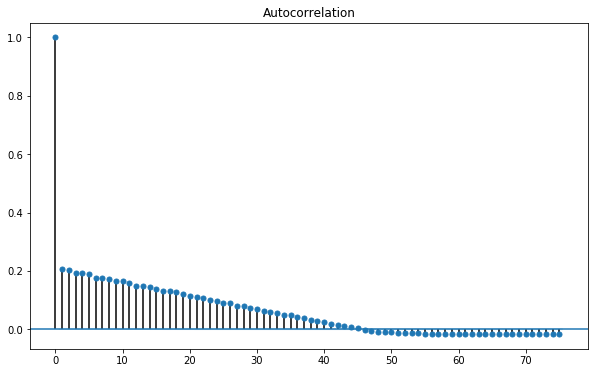

In [18]:
plt.figure(figsize = (10, 6))
plot_acf(df.QTY, lags = 75, ax = plt.gca());

In [20]:
list(df.keys())

['ITEM_ID',
 'DATE_ID',
 'STORE_ID',
 'CAT_DAYOFWEEK',
 'DUM_FREEWEEKDAY',
 'DUM_WORKSATURDAY',
 'DUM_SPRINGBREAK',
 'DUM_SUMMERBREAK',
 'DUM_FALLBREAK',
 'DUM_WINTERBREAK',
 'DUM_WORKDAY',
 'NUM_WORKDAYS_THISWEEK',
 'NUM_WORKDAYS_PASTWEEK',
 'NUM_WORKDAYS_NEXTWEEK',
 'NUM_WORKDAYS_PAST7DAY',
 'NUM_WORKDAYS_FRWD7DAY',
 'NUM_HOLIDAY_FROM',
 'NUM_HOLIDAY_TO',
 'NUM_HOLIDAY_SNGL_FROM',
 'NUM_HOLIDAY_SNGL_TO',
 'NUM_HOLIDAY_WHIT_FROM',
 'NUM_HOLIDAY_WHIT_TO',
 'NUM_HOLIDAY_XMAS_FROM',
 'NUM_HOLIDAY_XMAS_TO',
 'NUM_SCHOOLBREAK_FROM_END',
 'NUM_SCHOOLBREAK_TO_START',
 'NUM_SCHOOLBREAK_FROM_START',
 'NUM_SCHOOLBREAK_TO_END',
 'QTY',
 'PRICE',
 'CUSTOMER']

In [21]:
# Exclude: 
# - ID's, 
# - NANs
# - what we can't know at prediction time 
features = [col for col in list(df.keys()) if (col not in list(df.keys())[:3]) & \
                                              (col not in ['QTY', 'CUSTOMER'])]
features

['CAT_DAYOFWEEK',
 'DUM_FREEWEEKDAY',
 'DUM_WORKSATURDAY',
 'DUM_SPRINGBREAK',
 'DUM_SUMMERBREAK',
 'DUM_FALLBREAK',
 'DUM_WINTERBREAK',
 'DUM_WORKDAY',
 'NUM_WORKDAYS_THISWEEK',
 'NUM_WORKDAYS_PASTWEEK',
 'NUM_WORKDAYS_NEXTWEEK',
 'NUM_WORKDAYS_PAST7DAY',
 'NUM_WORKDAYS_FRWD7DAY',
 'NUM_HOLIDAY_FROM',
 'NUM_HOLIDAY_TO',
 'NUM_HOLIDAY_SNGL_FROM',
 'NUM_HOLIDAY_SNGL_TO',
 'NUM_HOLIDAY_WHIT_FROM',
 'NUM_HOLIDAY_WHIT_TO',
 'NUM_HOLIDAY_XMAS_FROM',
 'NUM_HOLIDAY_XMAS_TO',
 'NUM_SCHOOLBREAK_FROM_END',
 'NUM_SCHOOLBREAK_TO_START',
 'NUM_SCHOOLBREAK_FROM_START',
 'NUM_SCHOOLBREAK_TO_END',
 'PRICE']

Before we start splitting our data set, we first exclude the last month. We can compare it with our designed model later.

In [24]:
for store in list(df.STORE_ID.unique()):
    print(store, df[df.STORE_ID==store].DATE_ID.max())

0.0 1254.0
1.0 1254.0
2.0 1254.0
3.0 1254.0
4.0 1254.0
5.0 1254.0
6.0 1254.0
7.0 1254.0
8.0 1254.0
9.0 1254.0
10.0 1254.0
11.0 1254.0
12.0 1254.0
13.0 1254.0
14.0 1254.0
15.0 1254.0
16.0 1254.0
17.0 1254.0
18.0 1254.0
19.0 1254.0
20.0 1254.0
21.0 1254.0
22.0 1254.0
23.0 1254.0
24.0 1254.0
25.0 1254.0
26.0 1254.0
27.0 1254.0
29.0 1254.0
30.0 1254.0
31.0 1254.0
32.0 1254.0
33.0 1254.0
34.0 1254.0
35.0 1254.0
36.0 1254.0
37.0 1254.0
38.0 1254.0
39.0 1254.0
40.0 1254.0
41.0 1254.0
42.0 1254.0
43.0 1254.0
44.0 1254.0
45.0 1254.0
46.0 1254.0
47.0 1254.0
49.0 1254.0
48.0 1254.0
53.0 1254.0
50.0 1254.0
56.0 1254.0
54.0 1254.0
55.0 1254.0
58.0 1254.0
57.0 1254.0
28.0 1254.0
52.0 1254.0
60.0 1254.0


In [27]:
df_validation = df[df.DATE_ID >= df.DATE_ID.max()-30]
df_training = df.drop(df_validation.index)

In [29]:
seed = 20191103
y = df_training.QTY #np.log(df.QTY)
X = df_training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)

In [33]:
base_model_rf = RandomForestRegressor()
base_model_rf.fit(X_train[features],y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [43]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
#     print('Model Performance')
#     print('Mean Absolute Error: {:0.4f}'.format(np.mean(errors)))
#     print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return round(np.mean(errors),4) , round(accuracy,2)

In [35]:
evaluate(base_model_rf, X_test[features], y_test)

Model Performance
Mean Absolute Error: 898284273870239.1250
Accuracy = -43481375943140.33%.


There is no one size fits all solution. Instead we'll have to use our 1:1 approach for each store-item combination.

In [77]:
len(df.STORE_ID.unique())*len(df.ITEM_ID.unique())

1

There are 1357 possible combinations, thus 1357 different models.

In [81]:
dfs = []
for store in list(df.STORE_ID.unique()):
    for item in list(df.ITEM_ID.unique()):
        dfs.append(df[(df.STORE_ID == store) & (df.ITEM_ID == item)])

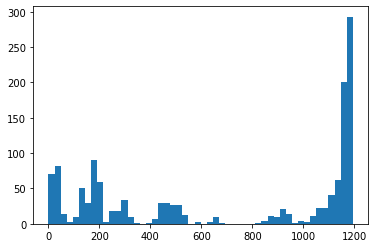

In [91]:
plt.hist([len(df) for df in dfs],bins=50)
plt.show()

In [92]:
dfs_new = [df for df in dfs if len(df) > 20]

In [110]:
results=[]
results_7days=[]
for df in dfs_new:
#     print(len(df))
    df_validation = df[df.DATE_ID >= df.DATE_ID.max()-7] # exclude last 7 days only (not much data)
    df_training = df.drop(df_validation.index)
    
    y = df_training.QTY #np.log(df.QTY)
    X = df_training
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)
    base_model_rf = RandomForestRegressor()
    base_model_rf.fit(X_train[features],y_train)
    results.append(evaluate(base_model_rf, X_test[features], y_test))
    results_7days.append(evaluate(base_model_rf, df_validation[features], df_validation.QTY))

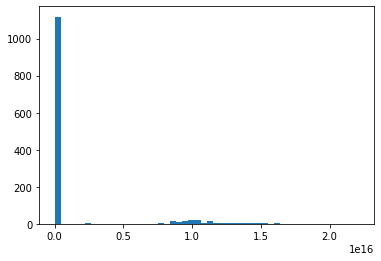

In [105]:
plt.hist(np.array(results)[:,0], bins=50)
plt.show()

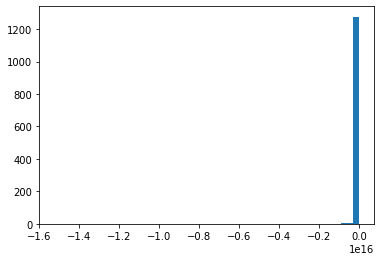

In [109]:
plt.hist(np.array(results)[:,1], bins=50)
plt.show()

OK. It looks like the simple worked for the majority, but not for all.

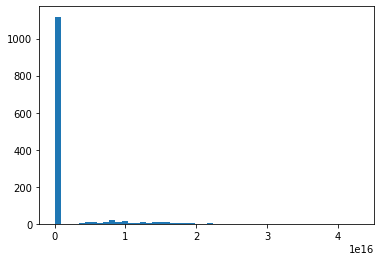

In [111]:
plt.hist(np.array(results_7days)[:,0], bins=50)
plt.show()

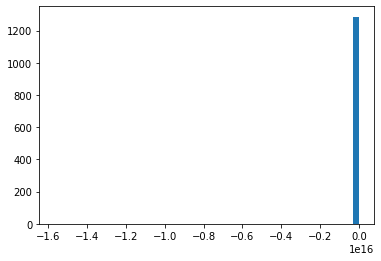

In [112]:
plt.hist(np.array(results_7days)[:,1], bins=50)
plt.show()

In [122]:
mae = np.array(results_7days)[:,0]

In [133]:
mae = mae[mae <30]
len(mae)

1099

In [134]:
mae.mean()

6.553911646951774